## Comparing models
We compare the three models we've trained using:
* Aggregate metrics
* Performance visualizations
* Dataset visualizations

In [1]:
from standard_libs import *

In [10]:
%load_ext autoreload
%autoreload 2

In [30]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

from ml_editor.data_processing import (
    format_raw_df,
    add_text_features_to_df,
    get_split_by_author,
    get_vectorized_series,
    get_vectorized_inputs_and_label,
    get_feature_vector_and_label
)


from ml_editor.model_evaluation import (
    get_feature_importance, 
    get_calibration_plot,
    get_metrics,
)
from ml_editor.model_v2 import POS_NAMES

In [23]:
data_path = Path('../data/writers_with_features.csv')
df = pd.read_csv(data_path)

In [24]:
clf_1 = joblib.load(Path('../models/model_1.pkl'))
vectorizer_1 = joblib.load(Path('../models/vectorizer_1.pkl'))
clf_2 = joblib.load(Path('../models/model_2.pkl'))
vectorizer_2 = joblib.load(Path('../models/vectorizer_2.pkl'))

clf_3 = joblib.load(Path('../models/model_3.pkl'))

In [25]:
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=42)

In [26]:
train_df['vectors'] = get_vectorized_series(train_df['full_text'].copy(), vectorizer_1)
test_df['vectors'] = get_vectorized_series(test_df['full_text'].copy(), vectorizer_1)

features_1 = [
    "action_verb_full",
    "question_mark_full",
    "text_len",
    "language_question",
]

features_2 = ["num_questions", 
               "num_periods",
               "num_commas",
               "num_exclam",
               "num_quotes",
               "num_colon",
               "num_stops",
               "num_semicolon",
               "num_words",
               "num_chars",
               "num_diff_words",
               "avg_word_len",
               "polarity"
              ]
features_2.extend(POS_NAMES.keys())

In [27]:
X_test_1, y_test = get_feature_vector_and_label(test_df, features_1)
X_test_2, y_test = get_feature_vector_and_label(test_df, features_2)

In [28]:
X_test_3 = test_df[features_2].astype(float)

In [29]:
clf1_predicted_proba = clf_1.predict_proba(X_test_1)
clf2_predicted_proba = clf_2.predict_proba(X_test_2)
clf3_predicted_proba = clf_3.predict_proba(X_test_3)

clf1_predicted = clf_1.predict(X_test_1)
clf2_predicted = clf_2.predict(X_test_2)
clf3_predicted = clf_3.predict(X_test_3)

In [31]:
for i, y_predicted in enumerate([clf1_predicted, clf2_predicted, clf3_predicted]):
    accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
    print("Model %s: Validation accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % ((i+1), accuracy, precision, recall, f1))

Model 1: Validation accuracy = 0.597, precision = 0.569, recall = 0.557, f1 = 0.563
Model 2: Validation accuracy = 0.589, precision = 0.565, recall = 0.512, f1 = 0.537
Model 3: Validation accuracy = 0.574, precision = 0.553, recall = 0.456, f1 = 0.500


### Comparing feature importance

In [32]:
def display_importance(clf, feature_names, k=10):
    print("Top %s importances:\n" % k)
    print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, feature_names)[:k]]))

    print("\nBottom %s importances:\n" % k)
    print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, feature_names)[-k:]]))

In [33]:
print("Model 1")
w_indices = vectorizer_1.get_feature_names()
w_indices.extend(features_1)
all_feature_1 = np.array(w_indices)
display_importance(clf_1, all_feature_1)

Model 1
Top 10 importances:

text_len: 0.0083
are: 0.0057
what: 0.0049
ve: 0.0047
writing: 0.0045
can: 0.0044
do: 0.0041
story: 0.0041
don: 0.004
not: 0.0037

Bottom 10 importances:

goodreads: 0
brilliance: 0
goods: 0
temperature: 0
brevity: 0
breeze: 0
temple: 0
plate: 0
bread: 0
lone: 0


In [34]:
print("Model 2")
w_indices = vectorizer_2.get_feature_names()
w_indices.extend(features_2)
all_feature_2 = np.array(w_indices)
display_importance(clf_2, all_feature_2)

Model 2
Top 10 importances:

num_chars: 0.0086
num_periods: 0.0081
num_diff_words: 0.0081
num_questions: 0.0073
ADJ: 0.0068
num_words: 0.0068
PUNCT: 0.0067
num_commas: 0.0067
DET: 0.0067
NOUN: 0.0066

Bottom 10 importances:

flee: 0
muscles: 0
balancing: 0
sexuality: 0
murky: 0
sh: 0
composition: 0
shady: 0
shake: 0
brush: 0


In [35]:
print("Model 3")
display_importance(clf_3, np.array(features_2))

Model 3
Top 10 importances:

num_questions: 0.049
num_periods: 0.049
num_chars: 0.049
num_diff_words: 0.049
ADV: 0.046
ADJ: 0.046
DET: 0.044
PART: 0.043
num_commas: 0.042
AUX: 0.042

Bottom 10 importances:

PROPN: 0.03
NUM: 0.024
num_colon: 0.022
num_quotes: 0.019
SYM: 0.014
INTJ: 0.013
X: 0.01
num_semicolon: 0.0071
num_exclam: 0.0069
CONJ: 0


### Comparing calibration
Next, we'll look at calibration, which is very important in an application were we want to show users meaningful scores representing the quality of their questions

In [36]:
def get_multiple_calibration_plot(predicted_proba_arrays, true_y, figsize=(10, 8)):
    """
    Inspired by sklearn example
    https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    :param figsize: size of the output figure
    :param predicted_proba_y: the predicted probabilities of our model for each example
    :param true_y: the true value of the label
    :return: calibration plot
    """

    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
#     print("\tBrier: %1.3f" % clf_score)
    
    for i,predicted_proba_y in enumerate(predicted_proba_arrays):
        fraction_of_positives, mean_predicted_value = calibration_curve(
            true_y, predicted_proba_y, n_bins=10
        )

        ax1.plot(
            mean_predicted_value,
            fraction_of_positives,
            "s-",
            label = "Model %s" % (i + 1)
        )

        ax2.hist(
            predicted_proba_y,
            range=(0, 1),
            bins=10,
            histtype="step",
            label = "Model %s" % (i + 1),
            lw=2,
        )

    ax1.set_ylabel("Fraction of positives")
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.legend(loc="lower right")
    ax1.set_title("Calibration plot")

    ax2.set_title("Probability distribution")
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper right", ncol=2)

    plt.tight_layout()

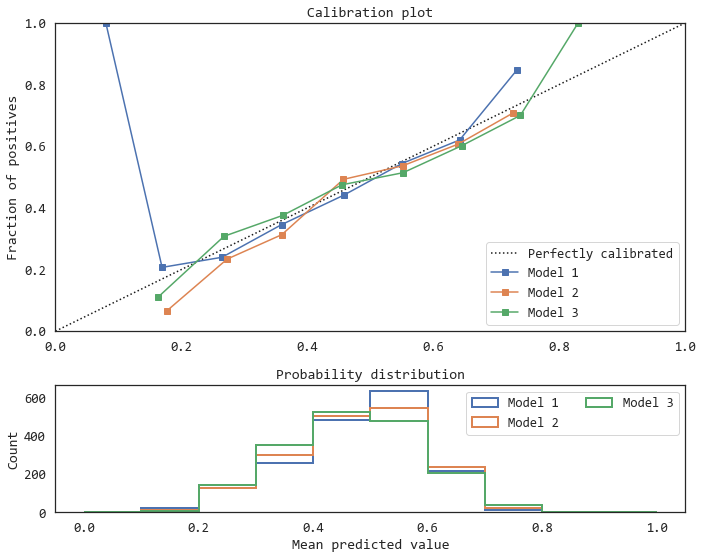

In [37]:
predictions = [clf1_predicted_proba[:,1], clf2_predicted_proba[:,1], clf3_predicted_proba[:,1]]

get_multiple_calibration_plot(predictions, y_test)

The results here look a bit different from what was given in the textbook. For some reason Model 2 with all the word vectors give a better calibration curve. Model 3 shoots up at predicted value of 0.9